Behavior of different numerical schemes for a moving shock wave.

We'll use a very busy road and a red light at x=4.  Cars will accumulate quickly in the front, where the max allowed density of cars will be between x=3 and x=4.  There is an incoming traffic of 50% the maximum allowed density ($\rho = 0.5 \rho_{max}$).

Mathematically it is $$\rho (x,0) = 0.5 \rho_{max}, 0 \leq x < 3$$
$$\rho (x,0) = \rho_{max}, 3 \leq x \leq 4$$

In [1]:
%matplotlib inline
import numpy
from matplotlib import pyplot
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16

In [2]:
def rho_red_light(nx, rho_max, rho_in):
    """Computes 'red light' initial condition with shock
    
    Parameters
    ----------
    nx : int
        Number of grid points in x
    rho_max : float
        Maximum allowed car density
    rho_in : float
        Density of incoming cars
    
    Returns
    -------
    rho : array of floats
        Array with initial values of density
    """
    rho = rho_max*numpy.ones(nx)
    rho[:(nx-1)*3./4.] = rho_in
    return rho

In [3]:
#Basic initial condition parameters
#defining grid size, time steps, CFL condition, etc...
nx = 81
nt = 30
dx = 4.0/(nx-1)

rho_in = 5.
rho_max = 10.

u_max = 1.

x = numpy.linspace(0,4,nx)

rho = rho_red_light(nx, rho_max, rho_in)

/Users/Michael/Applications/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:19: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


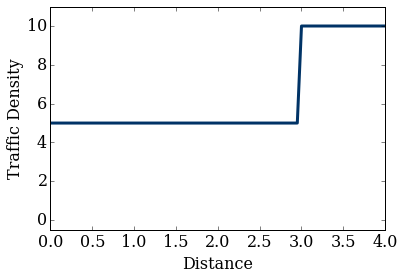

In [4]:
pyplot.plot(x, rho, color='#003366', ls='-', lw=3)
pyplot.ylabel('Traffic Density')
pyplot.xlabel('Distance')
pyplot.ylim(-0.5,11.);

**How will cars accumulate at the red light?**

The problem will be solved using three different numerical schemes and their performance will be looked at.

Lax-Friedrichs, Lax-Wendroff, and MacCormack

The wave speed $u_{wave}$ is -1 for $\rho = \rho _{max}$ and $\rho \leq \rho _{max} / 2$ which makes all velocities negative.  We should see a solution moving left, maintaining shock geometry. 

In [5]:
def computeF(u_max, rho_max, rho):
    """Computes flux F=V*rho
    
    Parameters
    ----------
    u_max : float
        Maximum allowed velocity
    rho : array of floats
        Array with density of cars at every point x
    rho_max : float
        Maximum allowed car density
        
    Returns
    -------
    F : array
        Array with flux at every point x
    """
    return u_max*rho*(1-rho/rho_max)